In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc = BrainObservatoryCache()

# Exercise: Evoked response

We want to put these different pieces of data together. Here will will find the preferred image for a neuron - the image among the natural scenes that drives the largest mean response - and see how that response is modulated by the mouse's running activity.

In [3]:
cell_specimen_id = 517474020
session_id = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], stimuli=['natural_scenes'])[0]['id']
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

Let's get the cell index for this cell specimen id:

In [4]:
cell_index = data_set.get_cell_specimen_indices([cell_specimen_id])[0]
print("Cell index: ", str(cell_index))

Cell index:  65


Let's start with the DF/F traces:

Text(0, 0.5, 'DF/F (%)')

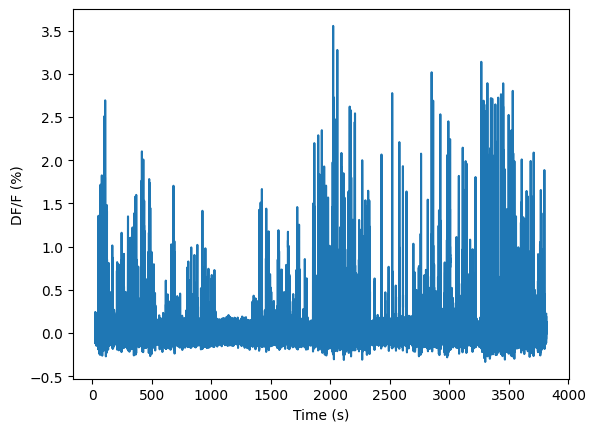

In [5]:
ts, dff = data_set.get_dff_traces()

plt.plot(ts, dff[cell_index,:])
plt.xlabel("Time (s)")
plt.ylabel("DF/F (%)")

Let's get the stimulus table for the natural scenes:

In [6]:
stim_table = data_set.get_stimulus_table('natural_scenes')
stim_table.head(n=10)

,frame,start,end
0,81,16100,16107
1,33,16108,16115
2,76,16115,16122
3,13,16123,16130
4,56,16130,16137
5,30,16138,16145
6,44,16145,16152
7,93,16153,16160
8,65,16160,16167
9,60,16168,16175


## Which image is the preferred image for this neuron?

For each trial of the natural scenes stimulus let's compute the mean response of the neuron's response and the mean running speed of the mouse.

Text(0, 0.5, 'Mean DF/F (%)')

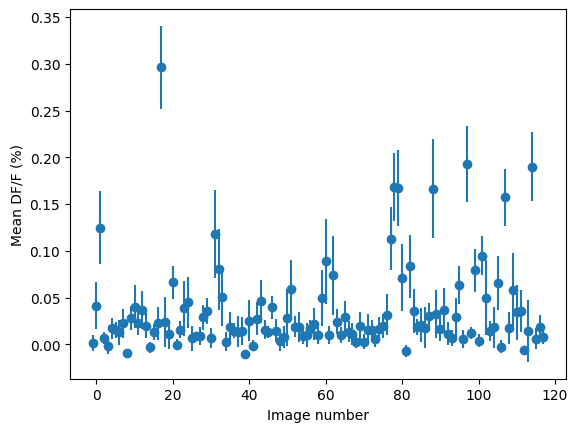

In [7]:
num_trials = len(stim_table)

trial_response = np.empty((num_trials))

for index, row in stim_table.iterrows():
    trial_response[index] = dff[cell_index, row.start:row.start+14].mean()

image_response = np.empty((119)) #number of images + blanksweep
image_sem = np.empty((119))
for i in range(-1,118):
    trials = stim_table[stim_table.frame==i].index.values
    image_response[i+1] = trial_response[trials].mean()
    image_sem[i+1] = trial_response[trials].std()/np.sqrt(len(trials))

plt.errorbar(range(-1,118), image_response, yerr=image_sem, fmt='o')
plt.xlabel("Image number")
plt.ylabel("Mean DF/F (%)")

Which image is the preferred image?

17


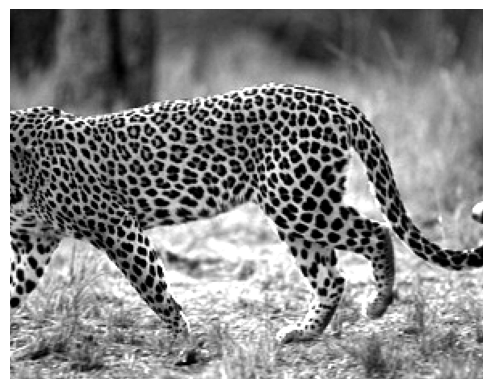

In [8]:
preferred_image = np.argmax(image_response) - 1
print(preferred_image)

natural_scene_template = data_set.get_stimulus_template('natural_scenes')
plt.imshow(natural_scene_template[preferred_image,:,:], cmap='gray')
plt.axis('off');

## How does the running activity influence the neuron's response to this image?

Let's get the running speed of the mouse:

Text(0, 0.5, 'Running speed (cm/s)')

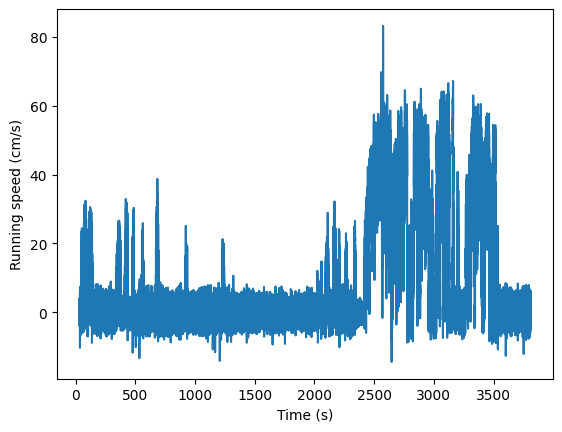

In [9]:
dxcm, _ = data_set.get_running_speed()

plt.plot(ts, dxcm)
plt.xlabel("Time (s)")
plt.ylabel("Running speed (cm/s)")

Compute the mean running speed during each trial. We will make a pandas dataframe with the mean trial response and the mean running speed

In [10]:
trial_speed = np.empty((num_trials))

for index, row in stim_table.iterrows():
    trial_speed[index] = dxcm[row.start:row.end].mean()

df = pd.DataFrame(columns=('response','speed'), index=stim_table.index)
df.response = trial_response
df.speed = trial_speed

stationary_mean = df[(stim_table.frame==preferred_image)&(df.speed<2)].mean()
running_mean = df[(stim_table.frame==preferred_image)&(df.speed>2)].mean()
print(stationary_mean.response.mean(), running_mean.response.mean())

0.21525957970297896 0.6203582406044006


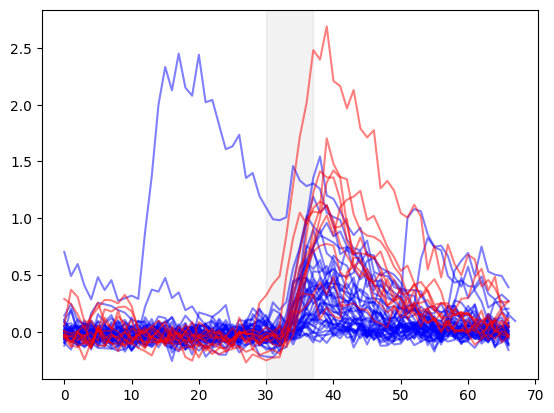

In [11]:
running_trials = stim_table[(stim_table.frame==preferred_image)&(df.speed>2)].index.values
stationary_trials = stim_table[(stim_table.frame==preferred_image)&(df.speed<2)].index.values

for trial in stationary_trials:
    plt.plot(dff[cell_index, stim_table.start.loc[trial]-30:stim_table.end.loc[trial]+30], color='blue', alpha=0.5)
for trial in running_trials:
    plt.plot(dff[cell_index, stim_table.start.loc[trial]-30:stim_table.end.loc[trial]+30], color='red', alpha=0.5)
plt.axvspan(xmin=30, xmax=37, color='gray', alpha=0.1)